                                       DATA MINING TECHNIQUES
                                             Project 1

                            Project implemented by undergraduate students:

                                           Gkatsis Vasileios
                                           Varsou Panagiota

In [1]:
#Importing all required libraries
import re
import pickle
import gensim
import nltk
import numpy as np
from os import path
import pandas as pd
from PIL import Image
from sklearn import svm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn import preprocessing
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

                    In the begining the program reads all data from data files 

In [2]:
#Read train data
colnames1 = ["Id1", "Id2", "Sentiment", "Text"]
data = pd.read_csv("../twitter_data/train2017.tsv", names=colnames1, sep="\t+", escapechar="\\", engine="python", header=None)

#Read test data
colnames2 = ["Id1", "Id2", "Sentiment", "Text"]
test_data = pd.read_csv("../twitter_data/test2017.tsv", names=colnames2, sep="\t+", escapechar="\\", engine="python", header=None)

#Read correct results
colnames3 = ["Id1","Sentiment"]
correct_data = pd.read_csv("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt", names=colnames3, sep="\t+", escapechar="\\", engine="python", header=None)

                                Do some preprocessing on read data

In [3]:
#Remove columns Id1 and Id2
data.drop(['Id1', 'Id2'], axis=1, inplace=True)

test_data.drop(['Id1', 'Id2'], axis=1, inplace=True)

correct_data.drop(['Id1'], axis=1, inplace=True)

                                    Transfer data into lists

In [4]:
#Store twitts in python lists
twitts = list()
test_twitts = list()

#Store the sentiment of each twitt into a list
twitts_sentiments = list()

#Also store the correct_resutls sentiments into a list
y_correct = list()

for text in data.iterrows():
    twitts.append([text[1].Text, text[1].Sentiment])
    twitts_sentiments.append(text[1].Sentiment)
    
for text in test_data.iterrows():
    test_twitts.append([text[1].Text, text[1].Sentiment])
    
for text in correct_data.iterrows():
    y_correct.append(text[1].Sentiment)

In [5]:
#Create a list for twitts of each sentiment
positive_tokens = list()
negative_tokens = list()
neutral_tokens = list()

#Create a list for clean tokens
clean_tokens = list()

clean_test_tokens = list()

                           The function defined next cleans and tokenizes twitts

In [6]:
def CleanAndTokenize(to_clean):
    #Remove non useful characters
    
    token = RegexpTokenizer(r'\w+')

    stopWords = set(stopwords.words('english'))

    clean_list = list()
    
    #Cleansing process
    for twitt_list in to_clean:
        twitt = twitt_list[0]
        #Remove HTML characters which have not been coded as text
        twitt = BeautifulSoup(twitt, 'lxml')
        twitt = twitt.get_text()
        #Remove words following '@'
        twitt = re.sub(r'@[A-Za-z0-9]+','',twitt)
        #Remove links
        twitt = re.sub('https?://[A-Za-z0-9./]+','',twitt)
        #Convert all letters to lower case
        twitt = twitt.lower()
        #Tokenizing
        twitt_tokens = token.tokenize(twitt)
        #Remove Stop Words
        clean_list += [[[word for word in twitt_tokens if word not in stopWords],twitt_list[1]]]
  
    return(clean_list)

                                        Preprocessing of data

In [7]:
#Apply CleanAndTokenize function to Train Twitts
clean_tokens = CleanAndTokenize(twitts)

#Apply CleanAndTokenize function to Test Twitts
clean_test_tokens = CleanAndTokenize(test_twitts)

                                 Categrise twitts according to sentiment

In [8]:
#Categorise into Positive, Negative and Neutral Twitts

all_tokens = list()
all_test_tokens = list()

for twitt_list in clean_tokens:
    if(twitt_list[1] == "positive"):
        positive_tokens.append(twitt_list[0])
    elif(twitt_list[1] == "negative"):
        negative_tokens.append(twitt_list[0])
    else:
        neutral_tokens.append(twitt_list[0])
    
    all_tokens.append(twitt_list[0])
    
for twitt_list in clean_test_tokens:
    all_test_tokens.append(twitt_list[0])

                            Stemming is the last stage of data preprocessing

In [9]:
#Create lists for clean Tokens
inter_tokens = list()
final_twitts = list()

#Create lists for clean Test Tokens
inter_test_tokens = list()
final_test_twitts = list()

#Stemming
sb = SnowballStemmer("english")

for twitt_list in clean_tokens:
    token_list = twitt_list[0]
    for token in token_list:
        inter_tokens.append(sb.stem(token))
    final_twitts.append([" ".join(inter_tokens),twitt_list[1]])
    del inter_tokens[:]

for twitt_list in clean_test_tokens:
    token_list = twitt_list[0]
    for token in token_list:
        inter_test_tokens.append(sb.stem(token))
    final_test_twitts.append(" ".join(inter_test_tokens))
    del inter_test_tokens[:]

                            Create lists of data for use in Word Cloud creation

In [10]:
wc_positive = " ".join([i for sub in positive_tokens for i in sub])
wc_negative = " ".join([i for sub in negative_tokens for i in sub])
wc_neutral = " ".join([i for sub in neutral_tokens for i in sub])
wc_general = " ".join([i for sub in all_tokens for i in sub])

                                       Create Word Cloud masks

In [11]:
twitter_mask = np.array(Image.open("twittersized.jpg"))

                            Remove stop words defined in wordcloud lib

In [12]:
#Add some extra Stop Words
unicode = {"u002c","u2019","u2019s","u2018","u2019t","u2019m"}
time_words = {"time","today","tomorrow","day","now","one","sunday","monday","friday","tuesday","thursday","saturday","night","tonight"}
extra_words = {"1st","2nd","3rd","really","know","still","say","look","right","think","last","come","want","one","going","go","sat","gonna","coming","take","may","new","see","got","make","back"}

stop_words = set(STOPWORDS)
stop_words.update(unicode)
stop_words.update(time_words)
stop_words.update(extra_words)

                                      Below is the creation of Word Clouds
                  
                                      The twitter symbol is used as a mask
               
                     A word cloud is produced for all twitts as well as for each one of the 
                                     Postive, Negative And Neutral Sentiments

                                    First word cloud for all twitts

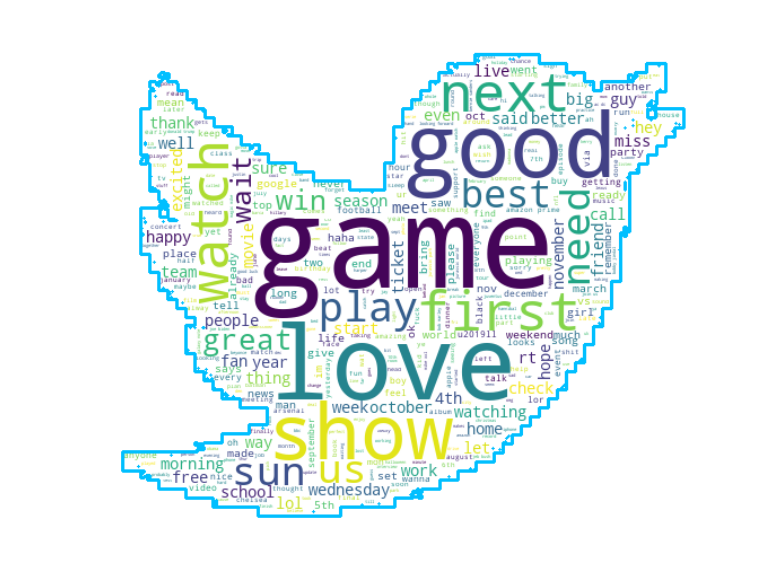

In [13]:
#Create a word cloud for all Twitter Data
wordcloud = WordCloud(stopwords=stop_words,max_words=1000,background_color="white",mask=twitter_mask,contour_width=2,contour_color='deepskyblue').generate(wc_general)

wordcloud.to_file("twitter_wordcloud.png")
#Plot the Word Cloud
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

                                 Second word cloud for positive twitts

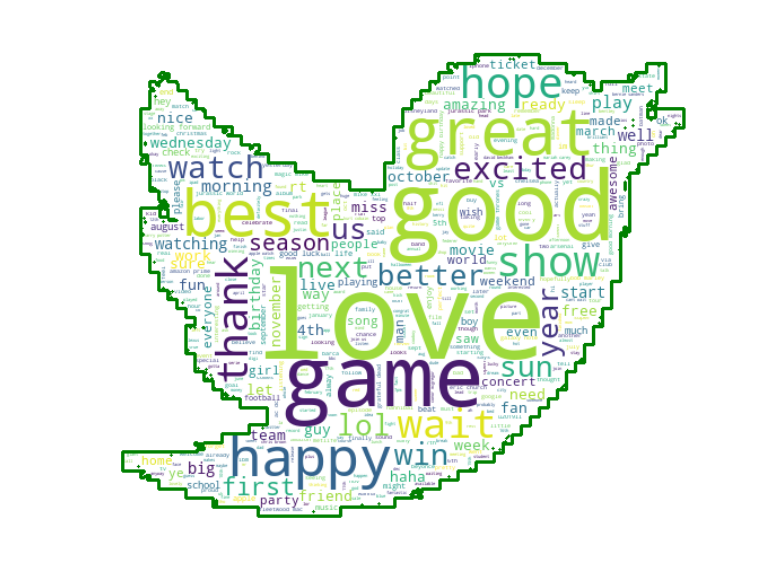

In [14]:
#Create a word cloud for Positive Twitter Data
wordcloud = WordCloud(stopwords=stop_words,max_words=1000,background_color="white",mask=twitter_mask,contour_width=2,contour_color='green').generate(wc_positive)

wordcloud.to_file("positive_wordcloud.png")
#Plot the Word Cloud
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

                                  Third word cloud for Negative Twitts

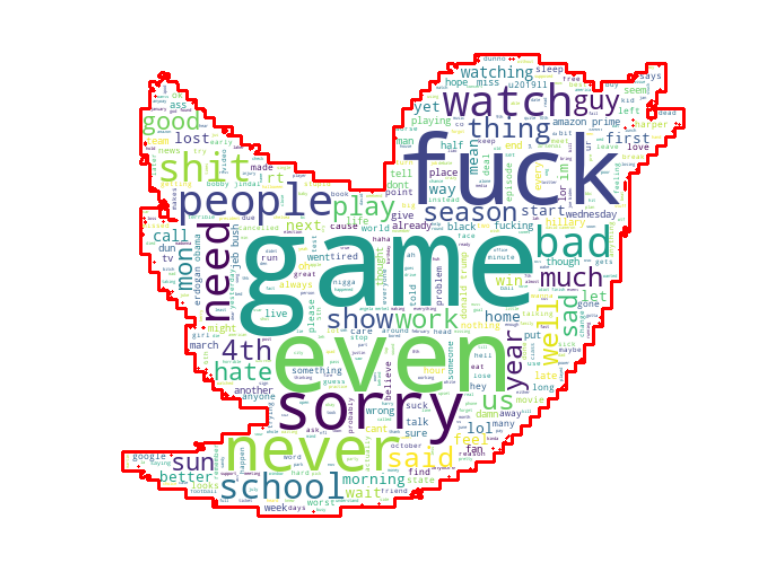

In [15]:
#Create a word cloud for Negative Twitter Data
wordcloud = WordCloud(stopwords=stop_words,max_words=1000,background_color="white",mask=twitter_mask,contour_width=2,contour_color='red').generate(wc_negative)

wordcloud.to_file("negative_wordcloud.png")
#Plot the Word Cloud
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

                  Τέταρτο Word Cloud Για Τα Neutral Twitts

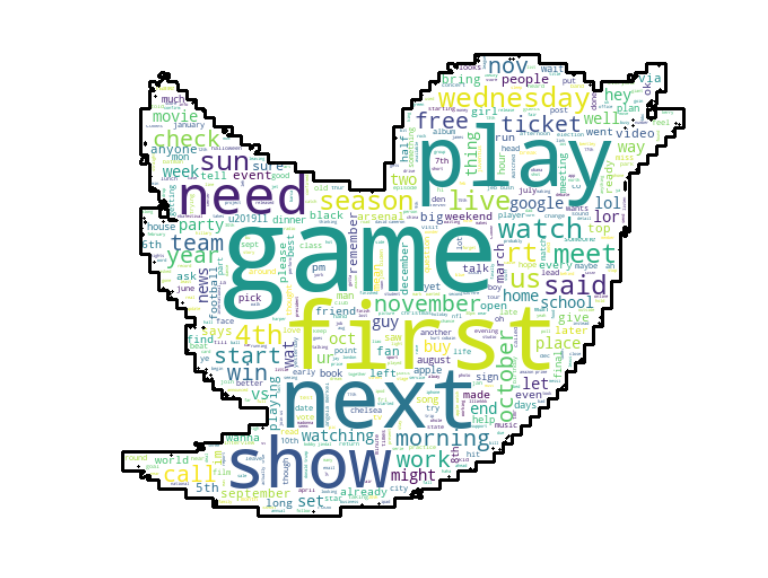

In [16]:
#Create word cloud for Neutral Twitter Data
wordcloud = WordCloud(stopwords=stop_words,max_words=1000,background_color="white",mask=twitter_mask,contour_width=2,contour_color='black').generate(wc_neutral)

wordcloud.to_file("neutral_wordcloud.png")
#Plot the Word Cloud
plt.figure(figsize=[20,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

                                     Word Cloud Observations:
      
           1)The procedure has been done corectly as in each sentiment's word cloud the dominant words are 
               those expressing that sentiment.
      
           2)The majority of twitts are positive. That conclusion comes form the fact that words with higher 
              frequency in the positive word cloud are the words with the higher frequency in the general 
              word cloud.

                       Next is Vectorization And the extraction of features

In [17]:
#Vectorization
vector_twitts = list()

for twitt_list in final_twitts:
    vector_twitts.append(twitt_list[0])

                            We create features for each one of the twitts

                                      First we use Bag Of Words

In [18]:
#a) Bag-Of-Words
bowvectorizer = CountVectorizer()

Bow = bowvectorizer.fit_transform(vector_twitts)

Bow_test = bowvectorizer.transform(final_test_twitts)

                                          Second Tf-Idf

In [19]:
#b) Tf-idf
tf_idfvectorizer = TfidfVectorizer()

Tf_Idf = tf_idfvectorizer.fit_transform(vector_twitts)

Tf_Idf_test = tf_idfvectorizer.transform(final_test_twitts)

                              As a last step we try our classifiers

In [21]:
#Create y_train Set
le = preprocessing.LabelEncoder()
le.fit(twitts_sentiments)
y_train = le.transform(twitts_sentiments)

                                                SVM

In [22]:
#Create Linear SVM classifier
clf = svm.SVC(kernel='linear')

                                             SVM - BOW

In [66]:
#Train the classifier
clf.fit(Bow, y_train)

#Make predictions on test data
clf_bow_predictions = clf.predict(Bow_test)

svm_bow_prediction = list()
y_pred = le.inverse_transform(clf_bow_predictions)

for i in y_pred:
    svm_bow_prediction.append(i)

#Calculate F1 score of SVM-BOW
print("\t\t\t\tSVM-BOW Score is: %.2f%%" % (f1_score(y_correct, svm_bow_prediction, average='weighted') * 100))

		SVM-BOW Score is: 56.21%


                                            SVM - Tf-Idf

In [67]:
#Train Classifier
clf.fit(Tf_Idf, y_train)

#Make Predictions On Unseen Test Data
clf_tf_idf_predictions = clf.predict(Tf_Idf_test)

svm_tf_prediction = list()
y_pred = le.inverse_transform(clf_tf_idf_predictions)
for i in y_pred:
    svm_tf_prediction.append(i)
#Calculate F1 score Of SVM-Tf_Idf
print("\t\t\tSVM-Tf-Idf Score is: %.2f%%" % (f1_score(y_correct, svm_tf_prediction, average='weighted') * 100))

			SVM-Tf-Idf Score is: 57.19%


          Results of SVM with BOW (56.21%) and Tf-Idf(57.19%) are quite good result for this method. 

                                           KNN

In [58]:
#Create KNN classifier
k_neighbours = KNeighborsClassifier(n_neighbors=7)

                                        KNN - BOW

In [63]:
#Train the Classifier
k_neighbours.fit(Bow, y_train)

#Make predictions on Test Data
k_n_predictions = k_neighbours.predict(Bow_test)

knn_bow_prediction = list()
y_pred = le.inverse_transform(k_n_predictions)

for i in y_pred:
    knn_bow_prediction.append(i)

#Calculate F1 score of KNN - BOW
print("\t\t\t\t    KNN-BOW Score is: %.2f%%" % (f1_score(y_correct, knn_bow_prediction, average='weighted') * 100))

				    KNN-BOW Score is: 36.40%


                                        KNN - Tf-Idf

In [60]:
#Train the CLassifier
k_neighbours.fit(Tf_Idf, y_train)

#Makepredictions on Test Data
k_n_predictions = k_neighbours.predict(Tf_Idf_test)

knn_tf_idf_prediction = list()
y_pred = le.inverse_transform(k_n_predictions)

for i in y_pred:
    knn_tf_idf_prediction.append(i)

#Υπολογίζουμε Το F1 Score Του KNN - Tf-Idf
print("\t\t\t\tKNN - Tf-Idf Score is: %.2f%%" % (f1_score(y_correct, knn_tf_idf_prediction, average='weighted') * 100))

				KNN - Tf-Idf Score is: 41.76%


    KNN with BOW gives a score of 36.4%. Since we have 3 categories for our data such a score is very close to 
        the score of random choosing a category which would be 33.3%. That result was expected.

    KNN with Tf-Idf gives a score of 41.76% slightly better than the score of KNN-BOW. That result was 
        also expected.